# A NOTEBOOK TO RUN NETWORK ANALYSIS ON SURFACE AREA DATA AVERAGED OVER CLUSTERS OF HCP PARCELS
Clusters of parcels are generated in R. Absolute surface area was averaged within the clusters and the data saved to the shared folder.

In [1]:
import itertools
# Import packages and scripts
import sys
from pathlib import Path
import pandas as pd
import scipy
from graph_tool.all import *
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import re
import scipy.stats as stats

common_path = Path("/workspace/scripts/common")
sys.path.append(str(common_path))
import networkfuncs # import networkfuncs script

# Nearest-neighbour (single linkage) clustering to 90 clusters
This data contains absolute surface area data averaged over left and right then summed within 90 clusters. The clusters were identified from nearest neighbour joining of lr-averaged absolute surface area in 650 controls.

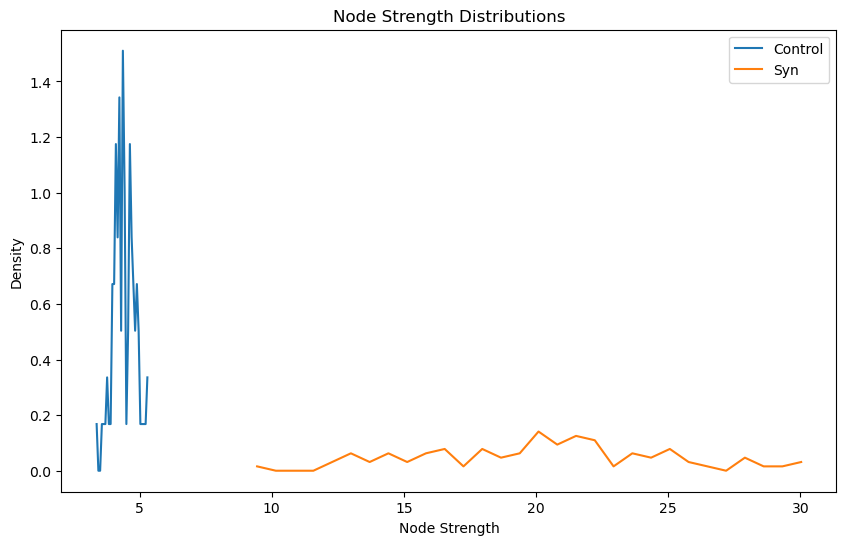

In [19]:
# Import data, generate graphs and plot strength distributions
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_sum.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

The node degree distributions look very different between the two full groups. Will this be the same if we use resampled data from the controls so the sample sizes match?

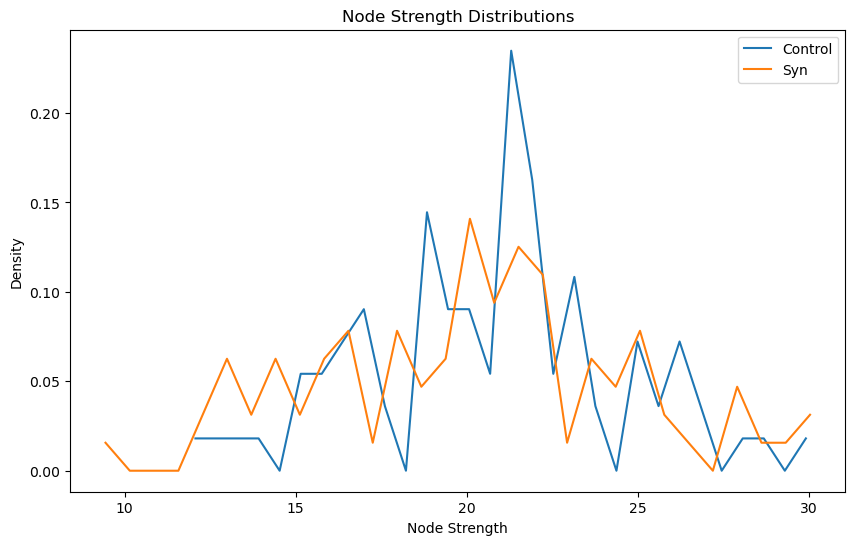

In [20]:
# Convert resampled data to graphs and plot strengths
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_sum_resamp.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

NB: The clusters are still derived from the nearest neighbour clustering of the full 650 controls.

The strength distributions are more similar for this resampled data.
This suggests that even for a reduced number of nodes, partial correlations are still affected by sample size.
We should see if there are any differences in network statistics, using multiple samples from the control dataset.

In [21]:
# Read data and generate graphs for controls and synesthetes
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('nn90_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_sum_syn.csv')

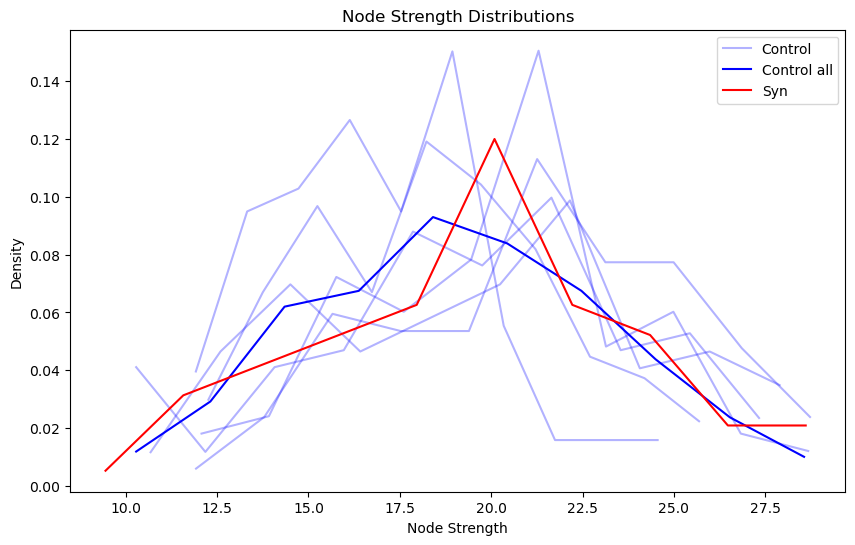

In [22]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=10, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=10, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.263090    0.299334  1.847060  0.000396  0.006671  Control
1    0.283576    0.316705  1.754623  0.000393  0.006503  Control
2    0.239478    0.282577  1.947568  0.000403  0.006971  Control
3    0.269842    0.297294  1.883150  0.000400  0.006852  Control
4    0.218316    0.262400  2.095005  0.000408  0.007213  Control
5    0.266642    0.292187  1.926831  0.000400  0.006827  Control
6    0.266221    0.293325  1.902216  0.000398  0.006770      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.256824    0.291750  1.909039  0.000400  0.006839
Syn        0.266221    0.293325  1.902216  0.000398  0.006770


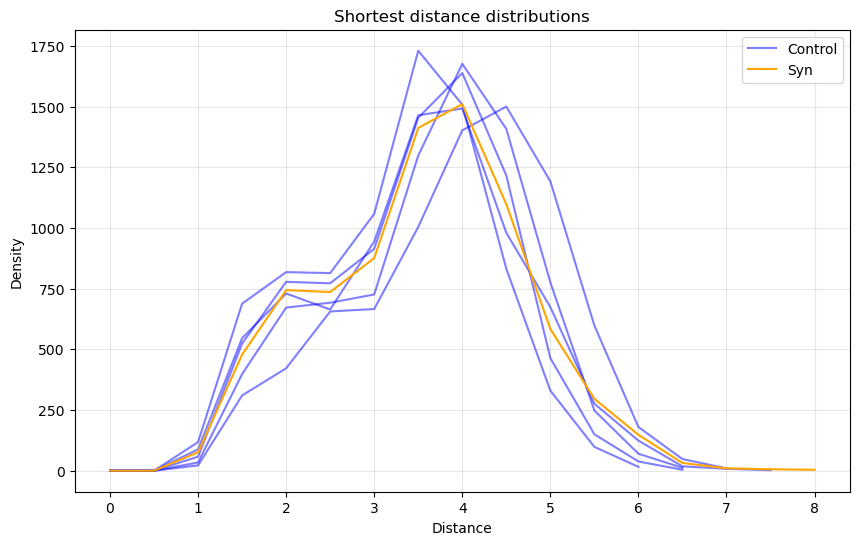

In [23]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 6 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:5]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[6][1][:-1], dist_hists[6][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

No clear differences with the nearest-neighbour clustering. Let's confirm with statistical testing before trying another approach.

In [24]:
# Test for normal distribution of metrics
stat, p_value = stats.shapiro(net_metrics['clustering'][net_metrics['Group'] == 'Control'])
print(f"Clustering - Shapiro-Wilk P-value{p_value}")
stat, p_value = stats.shapiro(net_metrics['efficiency'][net_metrics['Group'] == 'Control'])
print(f"Clustering - Shapiro-Wilk P-value{p_value}")

# T-tests
t = stats.ttest_1samp(net_metrics['clustering'][net_metrics['Group'] == 'Control'], net_metrics['clustering'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Clustering - T-test P-value: {t[1]}')
t = stats.ttest_1samp(net_metrics['efficiency'][net_metrics['Group'] == 'Control'], net_metrics['efficiency'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Efficiency - T-test P-value: {t[1]}')

Clustering - Shapiro-Wilk P-value0.5058325979999871
Clustering - Shapiro-Wilk P-value0.8868828926027046
Clustering - T-test P-value: 0.37574095250605444
Efficiency - T-test P-value: 0.8405203919063509


# Network analysis of 90 spectral clusters
In testing in R, we found that spectral clustering performed better than both nearest-neighbour with 90 clusters and Ward's hierarchical clustering with 60 clusters. Let's import the data and run the network analysis.

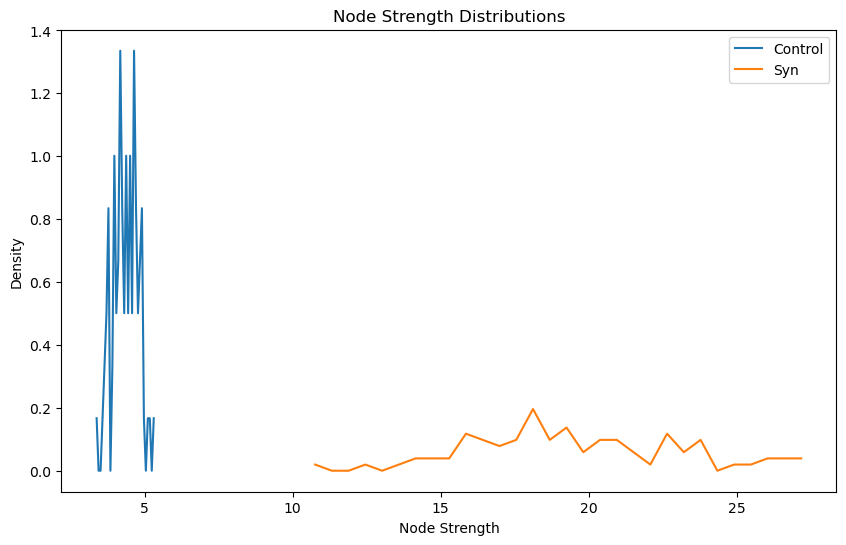

In [25]:
# Import data, convert to graphs and plot strengths
datapath = '/workspace/shared/synesthesia_100brains/surface_area/spectral_clust/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_spec90_sum.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

In [26]:
# Read data and generate graphs for controls and synesthetes
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('spec90_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_spec90_sum_syn.csv')

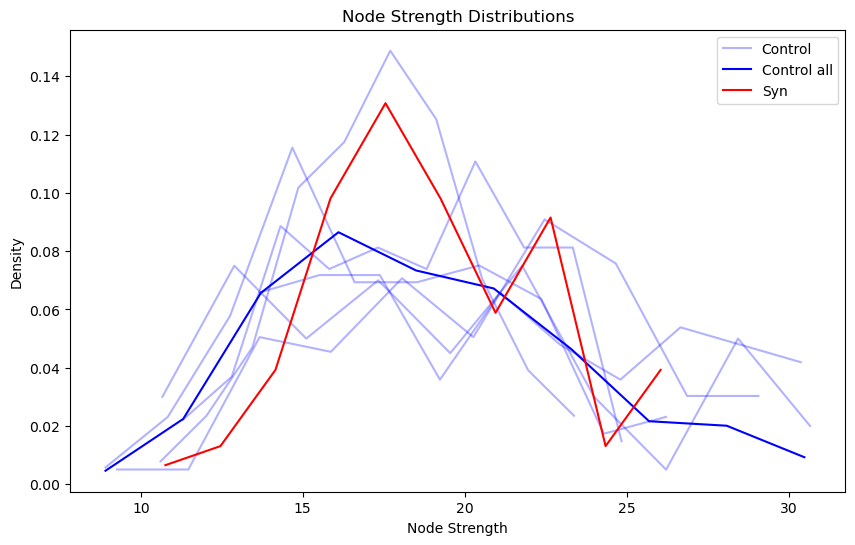

In [27]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=10, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=10, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.294749    0.311685  1.794946  0.000391  0.006415  Control
1    0.242344    0.272547  2.039330  0.000405  0.007071  Control
2    0.280510    0.308693  1.806428  0.000391  0.006441  Control
3    0.286460    0.289768  1.959619  0.000397  0.006705  Control
4    0.240224    0.282704  1.948822  0.000403  0.006971  Control
5    0.222053    0.267389  2.050509  0.000402  0.006954  Control
6    0.250211    0.289009  1.915005  0.000400  0.006832      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.261057    0.288798  1.933276  0.000398  0.006760
Syn        0.250211    0.289009  1.915005  0.000400  0.006832


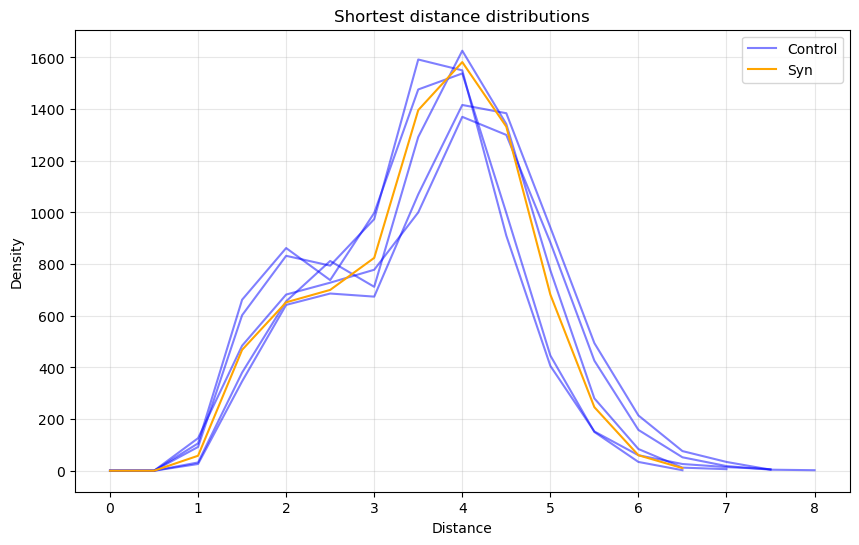

In [28]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 6 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:5]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[6][1][:-1], dist_hists[6][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

No clear differences with 90 spectral clusters. Again, let's check with statistical tests.

In [29]:
# Test for normal distribution of metrics
stat, p_value = stats.shapiro(net_metrics['clustering'][net_metrics['Group'] == 'Control'])
print(f"Clustering - Shapiro-Wilk P-value{p_value}")
stat, p_value = stats.shapiro(net_metrics['efficiency'][net_metrics['Group'] == 'Control'])
print(f"Clustering - Shapiro-Wilk P-value{p_value}")

# T-tests
t = stats.ttest_1samp(net_metrics['clustering'][net_metrics['Group'] == 'Control'], net_metrics['clustering'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Clustering - T-test P-value: {t[1]}')
t = stats.ttest_1samp(net_metrics['efficiency'][net_metrics['Group'] == 'Control'], net_metrics['efficiency'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Efficiency - T-test P-value: {t[1]}')

Clustering - Shapiro-Wilk P-value0.3263526590719171
Clustering - Shapiro-Wilk P-value0.4838508063624793
Clustering - T-test P-value: 0.4146721721107964
Efficiency - T-test P-value: 0.9785503134942963


# Ward's clustering to 60 clusters

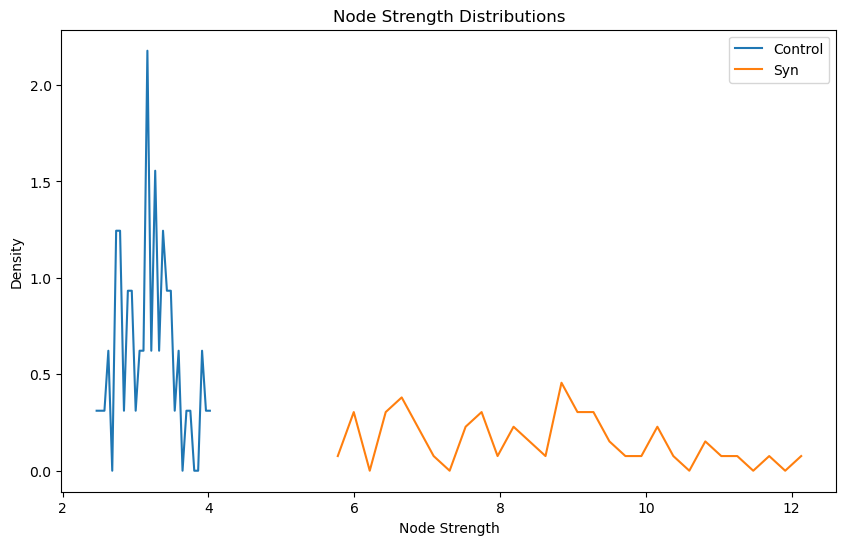

In [30]:
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_sum.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

In [31]:
# Read data and generate graphs for controls and synesthetes
datapath = '/workspace/shared/synesthesia_100brains/surface_area/hclust/' # set path to data
files = listdir(datapath)
cntrl_resamp = [str(file) for file in files if re.search('wrd60_sum_cntrl_resamp_[0-9]*.csv$', file)]
graphs_control = []
for file in cntrl_resamp:
    graphs_control.append(networkfuncs.data_to_graphs(datapath+file))
    
graph_syn = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_sum_syn.csv')

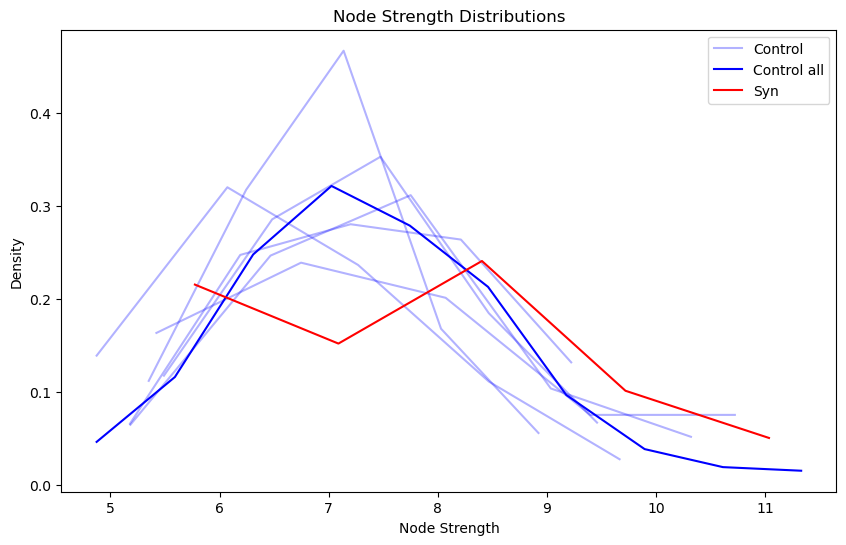

In [32]:
# Plot strength distributions
strengths_control = []
for graph in graphs_control: # for each graph
    weight = graph.edge_properties["weight"] # get edge weights
    strengths_control.append(graph.degree_property_map("total", weight = weight).a) # get total weight for each vertex
    
strengths_syn = graph_syn.degree_property_map("total", weight = graph_syn.edge_properties["weight"]).a # get syn strengths

fig = plt.figure(figsize=(10, 6)) # initialise figure
ax = fig.add_subplot(1, 1, 1) # add a single panel
for strength in strengths_control:   
    counts, bins = np.histogram(strength, bins=5, density=True)  # get the histogram of control strengths
    plt.plot(bins[:-1], counts, label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", alpha = 0.3, color = 'blue') # plot histograms
counts_mean, bins_mean = np.histogram(np.concat(strengths_control), bins=10, density=True) # get histogram of all control strengths
plt.plot(bins_mean[:-1], counts_mean, label="Control all", alpha = 1, color = 'blue') # plot histogram
counts, bins = np.histogram(strengths_syn, bins=5, density=True)  # get the histogram of synesthete strengths
plt.plot(bins[:-1], counts, label='Syn', color = 'red') # plot histogram
fig.set_facecolor('white') # make background white
ax.set_facecolor('white') # make background white
plt.xlabel("Node Strength") # x-axis title
plt.ylabel("Density") # y-axis title
plt.legend() # show the legend
plt.title("Node Strength Distributions") # set the title
plt.show() # show plot

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.141452    0.182638  3.013489  0.000954  0.011864  Control
1    0.152318    0.186878  2.965902  0.000949  0.011718  Control
2    0.129538    0.172521  3.167933  0.000945  0.011592  Control
3    0.146622    0.183765  3.004285  0.000937  0.011368  Control
4    0.131920    0.169040  3.275193  0.000956  0.011923  Control
5    0.139785    0.182105  3.021037  0.000954  0.011884  Control
6    0.158719    0.193442  2.859631  0.000934  0.011270      Syn
         clustering  efficiency     L_obs   mean_eb   mean_vb
Group                                                        
Control    0.140273    0.179491  3.074640  0.000949  0.011725
Syn        0.158719    0.193442  2.859631  0.000934  0.011270


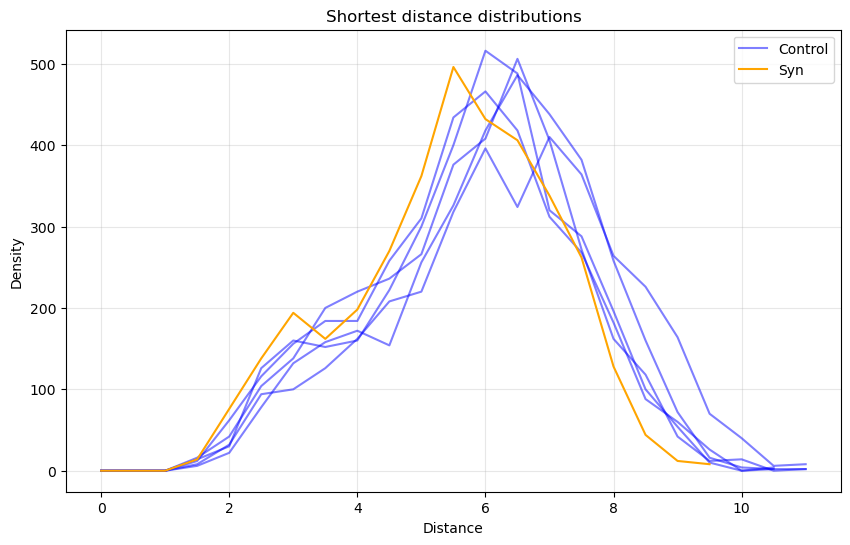

In [33]:
# Get network metrics
graphs = graphs_control + [graph_syn] # concatenate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control'] * 6 + ['Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results
print(net_metrics.groupby('Group').mean()) # print averaged results

plt.figure(figsize=(10, 6))

# below needs to change to get all controls
for hist in dist_hists[0:5]:
    plt.plot(hist[1][:-1], hist[0], label="Control" if 'Control' not in plt.gca().get_legend_handles_labels()[1] else "", color="blue", alpha = 0.5)

plt.plot(dist_hists[6][1][:-1], dist_hists[6][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Perhaps some small differences between the groups here? Let's test it out.

In [18]:
# T-test and effect sizes
# Global clustering coefficient
t = stats.ttest_1samp(net_metrics['clustering'][net_metrics['Group'] == 'Control'], net_metrics['clustering'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Clustering - T-test P-value: {t[1]}')
g = networkfuncs.hedges_g(data = net_metrics['clustering'][net_metrics['Group'] == 'Control'].to_numpy(), population_mean = net_metrics['clustering'][net_metrics['Group'] == 'Syn'].iloc[0]) # Hedge's g
print(f"Clustering - Hedge's g: {g}")

# Global efficiency
t = stats.ttest_1samp(net_metrics['efficiency'][net_metrics['Group'] == 'Control'], net_metrics['efficiency'][net_metrics['Group'] == 'Syn']) # one sample t-test
print(f'Efficiency - T-test P-value: {t[1]}')
g = networkfuncs.hedges_g(data = net_metrics['efficiency'][net_metrics['Group'] == 'Control'].to_numpy(), population_mean = net_metrics['efficiency'][net_metrics['Group'] == 'Syn'].iloc[0]) # Hedge's g
print(f"Efficiency - Hedge's g: {g}")


Clustering - T-test P-value: 0.003358377125683443
Clustering - Hedge's g: -1.8596128804382528
Efficiency - T-test P-value: 0.004640664884190936
Efficiency - Hedge's g: -1.724634383465427
